# ISMB figures notebook

In [1]:

include("engines/init.jl")
include("engines/data_processing.jl")
include("engines/deep_learning.jl")
include("engines/cross_validation.jl")
outpath, session_id = set_dirs() ;

  Activating project at `~/vae_cox`


┌ Error: Error during loading of extension FluxCUDAExt of Flux, use `Base.retry_load_extensions()` to retry.
│   exception = 1-element ExceptionStack:
InitError: Out of GPU memory
Stacktrace:
  [1] throw_api_error(res::CUDA.cudaError_enum)
    @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/libcuda.jl:25
  [2] check
    @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/libcuda.jl:34 [inlined]
  [3] cuDevicePrimaryCtxRetain
    @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/utils/call.jl:26 [inlined]
  [4] CUDA.CuContext(pctx::CUDA.CuPrimaryContext)
    @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/context.jl:57
  [5] context(dev::CUDA.CuDevice)
    @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/state.jl:253
  [6] CUDA.TaskLocalState(dev::CUDA.CuDevice)
    @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/state.jl:50
  [7] task_local_state!()
   

┌ Error: Error during loading of extension FluxCUDAExt of Flux, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    InitError: Out of GPU memory
│    Stacktrace:
│      [1] throw_api_error(res::CUDA.cudaError_enum)
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/libcuda.jl:25
│      [2] check
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/libcuda.jl:34 [inlined]
│      [3] cuDevicePrimaryCtxRetain
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/utils/call.jl:26 [inlined]
│      [4] CUDA.CuContext(pctx::CUDA.CuPrimaryContext)
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/context.jl:57
│      [5] context(dev::CUDA.CuDevice)
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/state.jl:253
│      [6] CUDA.TaskLocalState(dev::CUDA.CuDevice)
│        @ CUDA ~/.local/share/julia_GenuineInte

┌ Error: Error during loading of extension FluxCUDAExt of Flux, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    InitError: Out of GPU memory
│    Stacktrace:
│      [1] throw_api_error(res::CUDA.cudaError_enum)
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/libcuda.jl:25
│      [2] check
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/libcuda.jl:34 [inlined]
│      [3] cuDevicePrimaryCtxRetain
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/utils/call.jl:26 [inlined]
│      [4] CUDA.CuContext(pctx::CUDA.CuPrimaryContext)
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/context.jl:57
│      [5] context(dev::CUDA.CuDevice)
│        @ CUDA ~/.local/share/julia_GenuineIntel/packages/CUDA/rXson/lib/cudadrv/state.jl:253
│      [6] CUDA.TaskLocalState(dev::CUDA.CuDevice)
│        @ CUDA ~/.local/share/julia_GenuineInte

In [11]:
LGG = MLSurvDataset("Data/TCGA_LGG_tpm_n513_btypes_labels_surv.h5")

MLSurvDataset(Float32[3.21643 0.30103 … 0.0 1.4149734; 3.2214143 0.845098 … 0.47712126 1.9777236; … ; 3.299943 0.0 … 0.0 1.9138138; 3.067071 0.47712126 … 0.69897 1.80618], ["001ad307-4ad3-4f1d-b2fc-efc032871c7e", "0061e9ef-df6a-414e-af64-c88f8192e2d3", "0073a136-d5f4-4fd6-88f9-711768f2abc6", "00b18ad6-ff70-41fe-8f4d-0763ac8f28b9", "010aac75-3bfe-4bf2-b866-af0f2d92f125", "0167cf11-74be-4701-ab9a-4e057d4bb545", "019c5de9-74fd-48b7-95a3-227532e16c5a", "01a13aba-74a4-4895-a5ad-e5119925c202", "01c4ca12-ac08-41dd-9e4f-bfb0971688a2", "02194c0c-e2c1-4ea7-994a-07b61b2575e2"  …  "fc8828ae-484d-4fc8-a168-f8bc58ad65b9", "fcd9e1c4-bddb-4856-844c-03df48fba499", "fcf14e9d-4671-453d-b8e0-5008e916f56d", "fdff46a7-f92a-45cf-8756-6c73a406c923", "fe5c5c11-ef39-4907-9a70-67f37bb62fd7", "fea46eef-6b7f-44c3-93bf-2dec16bdeb79", "febe2ce5-737b-43b8-bc70-4194fe3ed5fb", "fee2114e-f723-4374-91f8-f1dcc6b3eaee", "ffcec8e5-9fd3-4b42-a7cb-74761f713cf4", "fff304a2-113f-499d-a88c-9d3660c348d9"], ["TSPAN6", "TNMD", "DPM

In [12]:
OV = MLSurvDataset("Data/TCGA_OV_tpm_n420_btypes_labels_surv.h5")

MLSurvDataset(Float32[3.2911468 0.7781513 … 1.1760913 2.3384564; 2.9527924 1.3617278 … 0.30103 1.5185139; … ; 3.4551494 0.30103 … 0.30103 2.0681858; 3.796019 0.60206 … 0.7781513 2.0530784], ["005a6517-2e5a-4ea3-ab36-531522723607", "01ea6354-137b-47f3-9021-a01a382b1147", "02594e5e-8751-47c1-9245-90c66984b665", "02d9aa2e-b16a-48ea-a420-5daed9fd51a6", "0484a929-7a7f-4926-8d25-470ddab082ec", "04ecaf38-0232-4dcd-9242-308a22cc1331", "05019013-7ea5-4905-ac79-901146ba2ee2", "05263959-c4f5-4540-b6d2-d8c8a128861f", "05ba5839-e00a-4a9e-8ba3-ecb490781e62", "062982f8-9f49-425a-99e9-008af5ed9040"  …  "f9793a4b-c0e7-4475-bf80-69543b7ee2f6", "f9c835db-2ab6-4bf5-826f-48723493c0ec", "f9f44f86-10c7-4473-b156-5afbfa9a2ad0", "fbb45305-de8d-4baf-8bd0-047b29c2e9d9", "fd4740db-76a8-4362-be71-7b609479bb67", "fdf83fdf-dfbb-4306-9a1b-b4487d18b402", "fe0e3851-d8cb-4533-9536-b4826cd25f87", "fe402983-70da-44db-b7b1-c32702ddde26", "fef1696c-a8f4-4db6-8615-e486522baaaa", "ff844242-7559-4b07-b09e-69ea40e5ac6b"], ["TSP

In [13]:
BRCA = MLSurvDataset("Data/TCGA_BRCA_tpm_n1049_btypes_labels_surv.h5")

MLSurvDataset(Float32[2.628389 0.60206 … 0.47712126 1.30103; 3.3195224 2.4843 … 0.90309 1.3617278; … ; 3.2151086 1.0413927 … 0.0 1.0791812; 3.328991 1.0 … 0.60206 1.5563025], ["001cef41-ff86-4d3f-a140-a647ac4b10a1", "0045349c-69d9-4306-a403-c9c1fa836644", "00807dae-9f4a-4fd1-aac2-82eb11bf2afb", "00a2d166-78c9-4687-a195-3d6315c27574", "00b11ca8-8540-4a3d-b602-ec754b00230b", "011b9b2d-ebe5-42bf-9662-d922faccc7a1", "01263518-5f7c-49dc-8d7e-84b0c03a6a63", "0130d616-885e-4a6c-9d03-2f17dd692a05", "01674b2c-5cf2-478f-84a1-f69c39f47bd4", "016caf42-4e19-4444-ab5d-6cf1e76c4afa"  …  "fb57c598-b45b-478a-9d34-ca1f050d5b7c", "fbee40f1-d6d8-4156-8d42-36e09bb9f095", "fc18d029-9be2-4fa0-9aef-6d647dc55f0b", "fcef8cb5-fb2c-4bfb-82cd-6b9f3145182c", "fd0b1b8b-1a76-480a-b61c-d176e4e02c6b", "fe15c48b-116d-461e-9b40-68514730fd18", "fe2cd610-aa52-4789-ac62-7683281bb22f", "fe7f74b8-20f4-4471-91dc-4cca8c68e5c0", "fec0da58-1047-44d2-b6d1-c18cceed43dc", "ff0f875f-113a-4c0f-8c0a-4259cd496e6d"], ["TSPAN6", "TNMD", "

In [14]:
LAML = MLSurvDataset("Data/LGN_AML_tpm_n300_btypes_labels_surv.h5") 

MLSurvDataset(Float32[0.008600163 0.0 … 0.0 0.0; 0.033423774 0.00432137 … 0.0 0.029383799; … ; 0.4828736 0.0 … 0.0 0.15836251; 0.045322984 0.017033324 … 0.0 0.20682588], ["01H001", "02H003", "02H009", "02H017", "02H026", "02H033", "02H053", "02H066", "03H016", "03H022"  …  "13H186", "14H001", "14H007", "14H012", "14H015", "14H017", "14H019", "14H020", "14H023", "14H038"], ["TSPAN6", "TNMD", "DPM1", "SCYL3", "C1orf112", "FGR", "CFH", "FUCA2", "GCLC", "NFYA"  …  "AP003086.3", "AL109627.1", "AC084851.4", "AC024558.2", "AC108479.4", "AL512357.2", "AL138899.3", "AL669830.1", "AC091135.2", "AL357075.5"], ["lncRNA", "lncRNA", "protein_coding", "lncRNA", "protein_coding", "lncRNA", "protein_coding,retained_intron", "lncRNA", "protein_coding", "protein_coding"  …  "transcribed_processed_pseudogene", "lncRNA", "processed_pseudogene", "protein_coding", "unprocessed_pseudogene", "lncRNA", "protein_coding", "retained_intron", "unprocessed_pseudogene", "protein_coding"], ["Therapy-related myeloid ne

In [28]:
cox_ridge = gpu(Chain(Dense(params_dict["insize"], 1, bias = false)))

Chain(
  Dense(14996 => 1; bias=false),        # 14_996 parameters
) 

In [37]:
ps1 = Flux.params(cox_ridge)
gs1 = gradient(ps1) do 
    cox_nll_vec(cox_ridge, train_x, train_y_e, NE_frac_tr) + l2_penalty(cox_ridge)
end 
Flux.update!(opt1,ps1, gs1)
vaecox_loss =  round(cox_nll_vec(cox_ridge, train_x, train_y_e, NE_frac_tr) + l2_penalty(cox_ridge) * wd , digits = 3)  
    

4.958

In [15]:
function format_train_test(fold; device = gpu)
    nsamples = size(fold["train_x"])[1]
    ordering = sortperm(-fold["Y_t_train"])
    train_x = device(Matrix(fold["train_x"][ordering,:]'));
    train_y_t = device(Matrix(fold["Y_t_train"][ordering,:]'));
    train_y_e = device(Matrix(fold["Y_e_train"][ordering,:]'));
    NE_frac_tr = sum(train_y_e .== 1) != 0 ? 1 / sum(train_y_e .== 1) : 0

    nsamples = size(fold["test_x"])[1]
    ordering = sortperm(-fold["Y_t_test"])
    test_x = device(Matrix(fold["test_x"][ordering,:]'));
    test_y_t = device(Matrix(fold["Y_t_test"][ordering,:]'));
    test_y_e = device(Matrix(fold["Y_e_test"][ordering,:]'));
    NE_frac_tst = sum(test_y_e .== 1) != 0 ? 1 / sum(test_y_e .== 1) : 0
    return train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst
end 

format_train_test (generic function with 1 method)

In [19]:
function data_prep_pca(DATA;nfolds = 5, nepochs =1000, dim_redux= 125)
    keep = [occursin("protein_coding", bt) for bt in DATA.biotypes]
    println("nb genes : $(sum(keep))")
    println("nb patients : $(size(DATA.samples)[1])")
    println("% uncensored : $(mean(DATA.surve .!= 0))")
    M = fit(PCA, Matrix(DATA.data[:,keep]'))
    pca_data = Matrix(predict(M, Matrix(DATA.data[:,keep]') )')
    params_dict = Dict(
            ## run infos 
            "session_id" => session_id, "nfolds" =>5,  "modelid" => "$(bytes2hex(sha256("$(now())"))[1:Int(floor(end/3))])",
            "machine_id"=>strip(read(`hostname`, String)), "device" => "$(device())", "model_title"=>"AECPHDNN",
            ## data infos 
            "dataset" => "LAML_pca", "nsamples" => size(DATA.samples)[1],
            "nsamples_test" => Int(round(size(DATA.samples)[1] / nfolds)), "ngenes" => size(DATA.genes[keep])[1],
            "nsamples_train" => size(DATA.samples)[1] - Int(round(size(DATA.samples)[1] / nfolds)),
            ## optim infos 
            "nepochs" => nepochs, "ae_lr" =>1e-6, "cph_lr" => 1e-5, "ae_wd" => 1e-6, "cph_wd" => 1e-6,
            ## model infos
            "model_type"=> "vaecox", "dim_redux" => dim_redux, "ae_nb_hls" => 2,
            "enc_nb_hl" => 2, "enc_hl_size"=> 128,
            "venc_nb_hl" => 2, "venc_hl_size"=> 128,  "dec_nb_hl" => 2 , "dec_hl_size"=> 128,
            "nb_clinf" => 0, "cph_nb_hl" => 2, "cph_hl_size" => 64, 
            "insize" => size(pca_data)[2],
            ## metrics
            "model_cv_complete" => false
        )
    # split train test
    
    folds = split_train_test(pca_data[:,1:30], DATA.survt, DATA.surve, DATA.samples;nfolds =5)
    fold = folds[1]
    # format input data  
    train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst = format_train_test(fold)

    return train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict
end

data_prep_pca (generic function with 1 method)

In [21]:
function VAE_COX_loss(VENC::VariationalEncoder, CPH, X, Y_e, NE_frac;device = gpu)
    mu, log_sigma = VENC(X)
    #z = mu + device(randn(Float32, size(log_sigma))) .* exp.(log_sigma)
    outs = vec(CPH(mu))
    hazard_ratios = exp.(outs)
    log_risk = log.(cumsum(hazard_ratios))
    uncensored_likelihood = outs .- log_risk
    censored_likelihood = uncensored_likelihood .* Y_e'
    #neg_likelihood = - sum(censored_likelihood) / sum(e .== 1)
    neg_likelihood = - sum(censored_likelihood) * NE_frac
    return neg_likelihood
end 

VAE_COX_loss (generic function with 1 method)

In [22]:
function VariationalEncoder(input_dim::Int, latent_dim::Int, hidden_dim::Int;device = gpu) 
    return VariationalEncoder(
    device(Chain(Dense(input_dim, hidden_dim, leakyrelu), Dense(hidden_dim,hidden_dim, leakyrelu))),   # linear
    device(Dense(hidden_dim, latent_dim)),        # mu
    device(Dense(hidden_dim, latent_dim)))        # log sigma
end 

VariationalEncoder

In [23]:
function l2_penalty(model::VariationalEncoder)
    l2_sum = 0
    for wm in model.linear
        l2_sum += sum(abs2, wm.weight)
    end 
    l2_sum += sum(abs2, model.mu.weight)
    l2_sum += sum(abs2, model.log_sigma.weight)
    return l2_sum
end

l2_penalty (generic function with 7 methods)

In [46]:
train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict = data_prep_pca(BRCA;nepochs = 10_000, dim_redux = 300)
venc = VariationalEncoder(size(train_x)[1], params_dict["dim_redux"], 600)
vdec = Decoder(size(train_x)[1], params_dict["dim_redux"], 600)
cphdnn = gpu(Chain(Dense(params_dict["dim_redux"],512, leakyrelu), Dense(512,512, leakyrelu), Dense(512, 1, bias = false)))
opt1 = Flux.ADAM(1e-7) ## opt VENC-CPHDNN
opt2 = Flux.ADAM(1e-5) ## opt VAE
wd = params_dict["cph_wd"]
opt = Flux.ADAM(params_dict["cph_lr"])
# training VAE only first
for i in 1:3000
    vaecox_loss =  round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd, digits = 3)  
    
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    ps2 = Flux.params(venc, vdec)
    gs2 = gradient(ps2) do 
        VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    #Flux.update!(opt1,ps1, gs1)
    Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end
# training VENC-CPHDNN 
for i in 1:params_dict["nepochs"]
    ps1 = Flux.params(cphdnn)
    gs1 = gradient(ps1) do 
        cox_nll_vec(cphdnn, venc(train_x)[1], train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd 
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vaecox_loss =  round(cox_nll_vec(cphdnn, venc(train_x)[1], train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd  , digits = 3)  
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    Flux.update!(opt1,ps1, gs1)
    #Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end
# training VENC-CPHDNN 
for i in 1:params_dict["nepochs"]
    ps1 = Flux.params(venc, cphdnn)
    gs1 = gradient(ps1) do 
        VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vaecox_loss =  round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd, digits = 3)  
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    Flux.update!(opt1,ps1, gs1)
    #Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end

nb genes : 19962
nb patients : 1049
% uncensored : 0.14013346043851288


1 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.027 	cind: 0.596 [1717, 1163, 0]


400 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.146 	cind: 0.596 [1717, 1163, 0]


800 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.257 	cind: 0.596 [1717, 1163, 0]


1200 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.39 	cind: 0.596 [1717, 1163, 0]


1600 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.524 	cind: 0.596 [1717, 1163, 0]


2000 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.567 	cind: 0.596 [1717, 1163, 0]


2400 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.642 	cind: 0.596 [1717, 1163, 0]


2800 TRAIN 5.544 cind: 0.479 	 TEST ae-corr: 0.679 	cind: 0.596 [1717, 1163, 0]


1 TRAIN 5.542 cind: 0.479 	 TEST ae-corr: 0.693 	cind: 0.596 [1717, 1163, 0]


400 TRAIN 5.504 cind: 0.492 	 TEST ae-corr: 0.695 	cind: 0.592 [1704, 1176, 0]


800 TRAIN 5.468 cind: 0.507 	 TEST ae-corr: 0.701 	cind: 0.592 [1706, 1174, 0]


1200 TRAIN 5.434 cind: 0.521 	 TEST ae-corr: 0.691 	cind: 0.592 [1704, 1176, 0]


1600 TRAIN 5.403 cind: 0.537 	 TEST ae-corr: 0.706 	cind: 0.585 [1686, 1194, 0]


2000 TRAIN 5.373 cind: 0.553 	 TEST ae-corr: 0.706 	cind: 0.583 [1680, 1200, 0]


2400 TRAIN 5.344 cind: 0.571 	 TEST ae-corr: 0.697 	cind: 0.581 [1674, 1206, 0]


2800 TRAIN 5.316 cind: 0.59 	 TEST ae-corr: 0.689 	cind: 0.581 [1673, 1207, 0]


3200 TRAIN 5.29 cind: 0.607 	 TEST ae-corr: 0.654 	cind: 0.585 [1686, 1194, 0]


3600 TRAIN 5.264 cind: 0.627 	 TEST ae-corr: 0.686 	cind: 0.582 [1677, 1203, 0]


4000 TRAIN 5.239 cind: 0.645 	 TEST ae-corr: 0.706 	cind: 0.582 [1677, 1203, 0]


4400 TRAIN 5.214 cind: 0.663 	 TEST ae-corr: 0.694 	cind: 0.585 [1685, 1195, 0]


4800 TRAIN 5.191 cind: 0.68 	 TEST ae-corr: 0.698 	cind: 0.586 [1688, 1192, 0]


5200 TRAIN 5.168 cind: 0.695 	 TEST ae-corr: 0.69 	cind: 0.591 [1701, 1179, 0]


5600 TRAIN 5.145 cind: 0.71 	 TEST ae-corr: 0.699 	cind: 0.59 [1699, 1181, 0]


6000 TRAIN 5.123 cind: 0.723 	 TEST ae-corr: 0.693 	cind: 0.592 [1706, 1174, 0]


6400 TRAIN 5.102 cind: 0.735 	 TEST ae-corr: 0.702 	cind: 0.594 [1712, 1168, 0]


6800 TRAIN 5.081 cind: 0.746 	 TEST ae-corr: 0.689 	cind: 0.595 [1715, 1165, 0]


7200 TRAIN 5.06 cind: 0.755 	 TEST ae-corr: 0.699 	cind: 0.599 [1725, 1155, 0]


7600 TRAIN 5.04 cind: 0.763 	 TEST ae-corr: 0.685 	cind: 0.599 [1726, 1154, 0]


8000 TRAIN 5.02 cind: 0.771 	 TEST ae-corr: 0.693 	cind: 0.6 [1729, 1151, 0]


8400 TRAIN 5.001 cind: 0.779 	 TEST ae-corr: 0.679 	cind: 0.601 [1731, 1149, 0]


8800 TRAIN 4.982 cind: 0.785 	 TEST ae-corr: 0.692 	cind: 0.601 [1730, 1150, 0]


9200 TRAIN 4.963 cind: 0.791 	 TEST ae-corr: 0.694 	cind: 0.602 [1733, 1147, 0]


9600 TRAIN 4.945 cind: 0.797 	 TEST ae-corr: 0.704 	cind: 0.601 [1730, 1150, 0]


10000 TRAIN 4.927 cind: 0.802 	 TEST ae-corr: 0.678 	cind: 0.601 [1730, 1150, 0]


1 TRAIN 4.928 cind: 0.802 	 TEST ae-corr: 0.677 	cind: 0.601 [1730, 1150, 0]


400 TRAIN 4.91 cind: 0.807 	 TEST ae-corr: 0.656 	cind: 0.601 [1732, 1148, 0]


800 TRAIN 4.893 cind: 0.811 	 TEST ae-corr: 0.704 	cind: 0.604 [1739, 1141, 0]


1200 TRAIN 4.875 cind: 0.816 	 TEST ae-corr: 0.69 	cind: 0.603 [1736, 1144, 0]


1600 TRAIN 4.858 cind: 0.819 	 TEST ae-corr: 0.691 	cind: 0.605 [1741, 1139, 0]


2000 TRAIN 4.841 cind: 0.824 	 TEST ae-corr: 0.682 	cind: 0.604 [1740, 1140, 0]


2400 TRAIN 4.824 cind: 0.827 	 TEST ae-corr: 0.693 	cind: 0.604 [1739, 1141, 0]


2800 TRAIN 4.808 cind: 0.831 	 TEST ae-corr: 0.684 	cind: 0.604 [1740, 1140, 0]


3200 TRAIN 4.791 cind: 0.834 	 TEST ae-corr: 0.694 	cind: 0.605 [1741, 1139, 0]


3600 TRAIN 4.775 cind: 0.838 	 TEST ae-corr: 0.686 	cind: 0.602 [1733, 1147, 0]


4000 TRAIN 4.759 cind: 0.841 	 TEST ae-corr: 0.676 	cind: 0.604 [1739, 1141, 0]


4400 TRAIN 4.743 cind: 0.844 	 TEST ae-corr: 0.687 	cind: 0.605 [1741, 1139, 0]


4800 TRAIN 4.727 cind: 0.847 	 TEST ae-corr: 0.683 	cind: 0.606 [1744, 1136, 0]


5200 TRAIN 4.711 cind: 0.85 	 TEST ae-corr: 0.694 	cind: 0.606 [1745, 1135, 0]


5600 TRAIN 4.696 cind: 0.853 	 TEST ae-corr: 0.693 	cind: 0.605 [1741, 1139, 0]


6000 TRAIN 4.68 cind: 0.857 	 TEST ae-corr: 0.677 	cind: 0.607 [1747, 1133, 0]


6400 TRAIN 4.665 cind: 0.86 	 TEST ae-corr: 0.695 	cind: 0.608 [1750, 1130, 0]


6800 TRAIN 4.649 cind: 0.863 	 TEST ae-corr: 0.702 	cind: 0.609 [1755, 1125, 0]


7200 TRAIN 4.634 cind: 0.865 	 TEST ae-corr: 0.703 	cind: 0.61 [1757, 1123, 0]


7600 TRAIN 4.619 cind: 0.868 	 TEST ae-corr: 0.679 	cind: 0.61 [1758, 1122, 0]


8000 TRAIN 4.604 cind: 0.871 	 TEST ae-corr: 0.705 	cind: 0.61 [1756, 1124, 0]


8400 TRAIN 4.589 cind: 0.873 	 TEST ae-corr: 0.684 	cind: 0.61 [1758, 1122, 0]


8800 TRAIN 4.574 cind: 0.876 	 TEST ae-corr: 0.687 	cind: 0.611 [1759, 1121, 0]


9200 TRAIN 4.559 cind: 0.878 	 TEST ae-corr: 0.668 	cind: 0.611 [1761, 1119, 0]


9600 TRAIN 4.545 cind: 0.88 	 TEST ae-corr: 0.69 	cind: 0.611 [1759, 1121, 0]


10000 TRAIN 4.53 cind: 0.883 	 TEST ae-corr: 0.687 	cind: 0.611 [1759, 1121, 0]


In [41]:
train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict = data_prep_pca(LAML;nepochs = 30_000, dim_redux = 125)
venc = VariationalEncoder(size(train_x)[1], params_dict["dim_redux"], 600)
vdec = Decoder(size(train_x)[1], params_dict["dim_redux"], 600)
cphdnn = gpu(Chain(Dense(params_dict["dim_redux"],512, leakyrelu), Dense(512,512, leakyrelu), Dense(512, 1, bias = false)))
opt1 = Flux.ADAM(1e-7) ## opt VENC-CPHDNN
opt2 = Flux.ADAM(1e-5) ## opt VAE
wd = params_dict["cph_wd"]
opt = Flux.ADAM(params_dict["cph_lr"])
for i in 1:params_dict["nepochs"]
    ps1 = Flux.params(venc, cphdnn)
    gs1 = gradient(ps1) do 
        VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vaecox_loss =  round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd, digits = 3)  
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    Flux.update!(opt1,ps1, gs1)
    #Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end

nb genes : 14996
nb patients : 300
% uncensored : 0.7433333333333333


1 TRAIN 4.912 cind: 0.553 	 TEST ae-corr: -0.012 	cind: 0.574 [951, 705, 0]


400 TRAIN 4.9 cind: 0.571 	 TEST ae-corr: 0.0 	cind: 0.58 [960, 696, 0]


800 TRAIN 4.887 cind: 0.589 	 TEST ae-corr: 0.017 	cind: 0.585 [969, 687, 0]


1200 TRAIN 4.875 cind: 0.609 	 TEST ae-corr: 0.002 	cind: 0.588 [974, 682, 0]


1600 TRAIN 4.863 cind: 0.627 	 TEST ae-corr: 0.007 	cind: 0.589 [975, 681, 0]


2000 TRAIN 4.852 cind: 0.642 	 TEST ae-corr: -0.019 	cind: 0.589 [976, 680, 0]


2400 TRAIN 4.841 cind: 0.656 	 TEST ae-corr: 0.014 	cind: 0.594 [984, 672, 0]


2800 TRAIN 4.83 cind: 0.666 	 TEST ae-corr: 0.02 	cind: 0.598 [991, 665, 0]


3200 TRAIN 4.82 cind: 0.677 	 TEST ae-corr: -0.009 	cind: 0.597 [989, 667, 0]


3600 TRAIN 4.809 cind: 0.684 	 TEST ae-corr: 0.05 	cind: 0.595 [986, 670, 0]


4000 TRAIN 4.799 cind: 0.692 	 TEST ae-corr: 0.022 	cind: 0.593 [982, 674, 0]


4400 TRAIN 4.789 cind: 0.699 	 TEST ae-corr: 0.009 	cind: 0.592 [981, 675, 0]


4800 TRAIN 4.78 cind: 0.704 	 TEST ae-corr: -0.008 	cind: 0.598 [991, 665, 0]


5200 TRAIN 4.77 cind: 0.708 	 TEST ae-corr: -0.021 	cind: 0.598 [990, 666, 0]


5600 TRAIN 4.761 cind: 0.714 	 TEST ae-corr: -0.018 	cind: 0.595 [985, 671, 0]


6000 TRAIN 4.752 cind: 0.718 	 TEST ae-corr: 0.018 	cind: 0.595 [985, 671, 0]


6400 TRAIN 4.743 cind: 0.722 	 TEST ae-corr: 0.008 	cind: 0.595 [986, 670, 0]


6800 TRAIN 4.734 cind: 0.726 	 TEST ae-corr: 0.002 	cind: 0.597 [989, 667, 0]


7200 TRAIN 4.726 cind: 0.728 	 TEST ae-corr: 0.011 	cind: 0.598 [991, 665, 0]


7600 TRAIN 4.717 cind: 0.731 	 TEST ae-corr: -0.024 	cind: 0.601 [996, 660, 0]


8000 TRAIN 4.709 cind: 0.735 	 TEST ae-corr: 0.003 	cind: 0.6 [993, 663, 0]


8400 TRAIN 4.701 cind: 0.737 	 TEST ae-corr: 0.017 	cind: 0.597 [989, 667, 0]


8800 TRAIN 4.692 cind: 0.74 	 TEST ae-corr: -0.006 	cind: 0.597 [988, 668, 0]


9200 TRAIN 4.684 cind: 0.742 	 TEST ae-corr: 0.02 	cind: 0.597 [989, 667, 0]


9600 TRAIN 4.677 cind: 0.745 	 TEST ae-corr: -0.0 	cind: 0.595 [986, 670, 0]


10000 TRAIN 4.669 cind: 0.748 	 TEST ae-corr: 0.003 	cind: 0.595 [986, 670, 0]


10400 TRAIN 4.661 cind: 0.75 	 TEST ae-corr: 0.002 	cind: 0.594 [983, 673, 0]


10800 TRAIN 4.654 cind: 0.752 	 TEST ae-corr: 0.022 	cind: 0.595 [985, 671, 0]


11200 TRAIN 4.646 cind: 0.755 	 TEST ae-corr: 0.009 	cind: 0.595 [985, 671, 0]


11600 TRAIN 4.639 cind: 0.756 	 TEST ae-corr: 0.018 	cind: 0.595 [986, 670, 0]


12000 TRAIN 4.632 cind: 0.758 	 TEST ae-corr: 0.025 	cind: 0.594 [984, 672, 0]


12400 TRAIN 4.624 cind: 0.76 	 TEST ae-corr: -0.018 	cind: 0.591 [979, 677, 0]


12800 TRAIN 4.617 cind: 0.762 	 TEST ae-corr: -0.006 	cind: 0.592 [981, 675, 0]


13200 TRAIN 4.61 cind: 0.763 	 TEST ae-corr: -0.001 	cind: 0.594 [984, 672, 0]


13600 TRAIN 4.604 cind: 0.765 	 TEST ae-corr: 0.008 	cind: 0.593 [982, 674, 0]


14000 TRAIN 4.597 cind: 0.767 	 TEST ae-corr: 0.013 	cind: 0.593 [982, 674, 0]


14400 TRAIN 4.59 cind: 0.769 	 TEST ae-corr: 0.015 	cind: 0.594 [983, 673, 0]


14800 TRAIN 4.583 cind: 0.771 	 TEST ae-corr: 0.019 	cind: 0.593 [982, 674, 0]


15200 TRAIN 4.577 cind: 0.772 	 TEST ae-corr: 0.006 	cind: 0.595 [985, 671, 0]


15600 TRAIN 4.57 cind: 0.774 	 TEST ae-corr: -0.031 	cind: 0.595 [985, 671, 0]


16000 TRAIN 4.564 cind: 0.775 	 TEST ae-corr: 0.008 	cind: 0.595 [985, 671, 0]


16400 TRAIN 4.557 cind: 0.776 	 TEST ae-corr: -0.006 	cind: 0.595 [985, 671, 0]


16800 TRAIN 4.551 cind: 0.778 	 TEST ae-corr: -0.003 	cind: 0.595 [986, 670, 0]


17200 TRAIN 4.544 cind: 0.779 	 TEST ae-corr: 0.015 	cind: 0.595 [986, 670, 0]


17600 TRAIN 4.538 cind: 0.78 	 TEST ae-corr: 0.004 	cind: 0.595 [986, 670, 0]


18000 TRAIN 4.532 cind: 0.782 	 TEST ae-corr: 0.013 	cind: 0.595 [986, 670, 0]


18400 TRAIN 4.526 cind: 0.783 	 TEST ae-corr: -0.004 	cind: 0.597 [988, 668, 0]


18800 TRAIN 4.52 cind: 0.784 	 TEST ae-corr: -0.025 	cind: 0.596 [987, 669, 0]


19200 TRAIN 4.514 cind: 0.785 	 TEST ae-corr: -0.011 	cind: 0.595 [986, 670, 0]


19600 TRAIN 4.508 cind: 0.786 	 TEST ae-corr: 0.002 	cind: 0.594 [984, 672, 0]


20000 TRAIN 4.502 cind: 0.787 	 TEST ae-corr: -0.011 	cind: 0.596 [987, 669, 0]


20400 TRAIN 4.496 cind: 0.788 	 TEST ae-corr: 0.0 	cind: 0.595 [986, 670, 0]


20800 TRAIN 4.49 cind: 0.789 	 TEST ae-corr: -0.036 	cind: 0.595 [985, 671, 0]


21200 TRAIN 4.484 cind: 0.79 	 TEST ae-corr: 0.029 	cind: 0.596 [987, 669, 0]


21600 TRAIN 4.478 cind: 0.791 	 TEST ae-corr: 0.001 	cind: 0.595 [985, 671, 0]


22000 TRAIN 4.472 cind: 0.792 	 TEST ae-corr: -0.005 	cind: 0.593 [982, 674, 0]


22400 TRAIN 4.467 cind: 0.793 	 TEST ae-corr: 0.002 	cind: 0.594 [984, 672, 0]


22800 TRAIN 4.461 cind: 0.795 	 TEST ae-corr: 0.017 	cind: 0.593 [982, 674, 0]


23200 TRAIN 4.455 cind: 0.796 	 TEST ae-corr: -0.006 	cind: 0.591 [979, 677, 0]


23600 TRAIN 4.45 cind: 0.797 	 TEST ae-corr: -0.006 	cind: 0.591 [978, 678, 0]


24000 TRAIN 4.444 cind: 0.798 	 TEST ae-corr: 0.021 	cind: 0.591 [979, 677, 0]


24400 TRAIN 4.439 cind: 0.799 	 TEST ae-corr: 0.02 	cind: 0.589 [976, 680, 0]


24800 TRAIN 4.433 cind: 0.8 	 TEST ae-corr: 0.022 	cind: 0.59 [977, 679, 0]


25200 TRAIN 4.428 cind: 0.801 	 TEST ae-corr: 0.0 	cind: 0.589 [975, 681, 0]


25600 TRAIN 4.422 cind: 0.802 	 TEST ae-corr: 0.041 	cind: 0.589 [975, 681, 0]


26000 TRAIN 4.417 cind: 0.803 	 TEST ae-corr: -0.02 	cind: 0.59 [977, 679, 0]


26400 TRAIN 4.411 cind: 0.804 	 TEST ae-corr: -0.019 	cind: 0.589 [975, 681, 0]


26800 TRAIN 4.406 cind: 0.805 	 TEST ae-corr: -0.034 	cind: 0.588 [974, 682, 0]


27200 TRAIN 4.401 cind: 0.805 	 TEST ae-corr: 0.003 	cind: 0.588 [973, 683, 0]


27600 TRAIN 4.396 cind: 0.807 	 TEST ae-corr: 0.011 	cind: 0.589 [975, 681, 0]


28000 TRAIN 4.39 cind: 0.807 	 TEST ae-corr: -0.001 	cind: 0.589 [976, 680, 0]


28400 TRAIN 4.385 cind: 0.808 	 TEST ae-corr: 0.033 	cind: 0.591 [978, 678, 0]


28800 TRAIN 4.38 cind: 0.809 	 TEST ae-corr: -0.016 	cind: 0.59 [977, 679, 0]


29200 TRAIN 4.375 cind: 0.811 	 TEST ae-corr: -0.04 	cind: 0.592 [980, 676, 0]


29600 TRAIN 4.37 cind: 0.811 	 TEST ae-corr: 0.016 	cind: 0.591 [979, 677, 0]


30000 TRAIN 4.365 cind: 0.812 	 TEST ae-corr: -0.025 	cind: 0.592 [980, 676, 0]


In [ ]:
function validate_vaecox(DATA, params_dict;device = gpu)
    nfolds, nepochs, dim_redux = 5, 1000, 125
    keep = [occursin("protein_coding", bt) for bt in DATA.biotypes]
    # split train test
    folds = split_train_test(Matrix(DATA.data[:,keep]), DATA.survt, DATA.surve, DATA.samples;nfolds =5)
    fold = folds[1]

    venc = VariationalEncoder(size(DATA.data[:,keep])[2], 125, 600)
    vdec = Decoder(size(DATA.data[:,keep])[2], 125, 600)
    VAE_opt = Flux.ADAM(1e-4)

    cphdnn = device(Chain(Dense(size(DATA.data[:,keep])[2], 125, leakyrelu), Dense(125, 100,leakyrelu),Dense(100, 1)))
    cphdnn_opt = Flux.ADAM(1e-5)

    train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst = format_train_test(fold)
    for i in 1:nepochs
        ps1 = Flux.params(venc, vdec)
        gs1 = gradient(ps1) do
            VAE_lossf(venc, vdec, train_x)
        end 
        VAE_loss = VAE_lossf(venc, vdec, train_x)
        VAE_cor = round(my_cor(vec(train_x), vec(MyReconstruct(venc, vdec, train_x)[end])),digits = 3)
        VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

        ps2 = Flux.params(venc, cphdnn)
        gs2 = gradient(ps2) do 
            cox_nll_vec(cphdnn, train_x, train_y_e, NE_frac_tr)
            #VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr)
        end 
        CPH_loss = round(cox_nll_vec(cphdnn, train_x, train_y_e, NE_frac_tr), digits = 3) #round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr), digits = 3)
        #mu, log_sigma = venc(train_x)
        #z = mu + device(randn(Float32, size(log_sigma))) .* exp.(log_sigma)
        #OUTS_tr = vec(cphdnn(z))
        OUTS_tr = cphdnn(train_x)
        OUTS_tst =  cphdnn(test_x)
        cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, OUTS_tr)
        cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e,OUTS_tst)
        #Flux.update!(VAE_opt, ps1, gs1)
        Flux.update!(cphdnn_opt, ps2, gs2)
        if i % 100 == 0 || i == 1
            println("$i TRAIN - VAE-loss-avg: $VAE_loss\tVAE-cor: $VAE_cor CPH-loss: $CPH_loss CPH-cind: $(round(cind_tr,digits=3))")
            println("$i TEST - VAE-loss-avg: $VAE_test \tVAE-cor: CPH-loss: CPH-cind: $(round(cind_test,digits=3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")

        end
    end
    return cphdnn
end 

In [ ]:
cdnn = validate_vaecox(DATA, params_dict)

In [ ]:
cdnn(DATA.data[])

In [96]:
train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict = data_prep(LAML)
# create model 
model = build_aecox(params_dict)
for iter in 1:params_dict["nepochs"]
    ps1 = Flux.params(model["cph"].model, model["enc"])
    gs1 = gradient(ps1) do
        model["cph"].lossf(model["cph"],model["enc"], train_x, train_y_e, NE_frac_tr, params_dict["cph_wd"])
    end 
    ## gradient Auto-Encoder 
    ps2 = Flux.params(model["ae"].net)
    gs2 = gradient(ps2) do
        model["ae"].lossf(model["ae"], train_x, train_x, weight_decay = params_dict["ae_wd"])
    end
    Flux.update!(model["cph"].opt, ps1, gs1)
    #Flux.update!(model["ae"].opt, ps2, gs2)

    ######
    OUTS_tr = vec(model["cph"].model(model["enc"](train_x)))
    ae_loss = model["ae"].lossf(model["ae"], train_x, train_x, weight_decay = params_dict["ae_wd"])
    ae_cor =  round(my_cor(vec(train_x), vec(model["ae"].net(train_x))),digits = 3)
    cph_loss = model["cph"].lossf(model["cph"],model["enc"](train_x), train_y_e, NE_frac_tr, params_dict["cph_wd"])
    ae_loss_test = round(model["ae"].lossf(model["ae"], test_x, test_x, weight_decay = params_dict["ae_wd"]), digits = 3)
    ae_cor_test = round(my_cor(vec(test_x), vec(model["ae"].net(test_x))), digits= 3)
    cph_loss_test = round(model["cph"].lossf(model["cph"],model["enc"](test_x), test_y_e, NE_frac_tst, params_dict["cph_wd"]), digits= 3)
                    
    OUTS_tst =  vec(model["cph"].model(model["enc"](test_x)))
            
    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e,OUTS_tst)
    if iter % 100 == 0  || iter == 1     
        println("FOLD $iter\t TRAIN AE-loss $(round(ae_loss,digits =3)) \t AE-cor: $(round(ae_cor, digits = 3))\t cph-loss-avg: $(round(cph_loss / params_dict["nsamples_train"],digits =6)) \t cph-cind: $(round(cind_tr,digits =3))")
        println("\t\tTEST AE-loss $(round(ae_loss_test,digits =3)) \t AE-cor: $(round(ae_cor_test, digits = 3))\t cph-loss-avg: $(round(cph_loss_test / params_dict["nsamples_test"],digits =6)) \t cph-cind: $(round(cind_test,digits =3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end
    params_dict["cph_tst_c_ind"] = concordance_index(test_y_t, test_y_e, OUTS_tst)[1]
    params_dict["cph_train_c_ind"] = concordance_index(train_y_t, train_y_e, OUTS_tr)[1]
    params_dict["step"] = iter 
end


nb genes : 14996
nb patients : 300
% uncensored : 0.7433333333333333


FOLD 1	 TRAIN AE-loss 0.994 	 AE-cor: 0.008	 cph-loss-avg: 0.020545 	 cph-cind: 0.611
		TEST AE-loss 0.991 	 AE-cor: 0.006	 cph-loss-avg: 0.058383 	 cph-cind: 0.515 [836, 788, 0]


FOLD 100	 TRAIN AE-loss 0.972 	 AE-cor: 0.004	 cph-loss-avg: 0.019126 	 cph-cind: 0.827
		TEST AE-loss 0.97 	 AE-cor: 0.002	 cph-loss-avg: 0.0563 	 cph-cind: 0.657 [1067, 557, 0]


FOLD 200	 TRAIN AE-loss 0.969 	 AE-cor: 0.004	 cph-loss-avg: 0.018949 	 cph-cind: 0.863
		TEST AE-loss 0.967 	 AE-cor: 0.002	 cph-loss-avg: 0.056367 	 cph-cind: 0.646 [1049, 575, 0]


FOLD 300	 TRAIN AE-loss 0.966 	 AE-cor: 0.004	 cph-loss-avg: 0.018913 	 cph-cind: 0.875
		TEST AE-loss 0.965 	 AE-cor: 0.002	 cph-loss-avg: 0.0564 	 cph-cind: 0.643 [1045, 579, 0]


FOLD 400	 TRAIN AE-loss 0.964 	 AE-cor: 0.004	 cph-loss-avg: 0.018904 	 cph-cind: 0.881
		TEST AE-loss 0.963 	 AE-cor: 0.002	 cph-loss-avg: 0.056483 	 cph-cind: 0.638 [1036, 588, 0]


FOLD 500	 TRAIN AE-loss 0.963 	 AE-cor: 0.005	 cph-loss-avg: 0.018899 	 cph-cind: 0.883
		TEST AE-loss 0.962 	 AE-cor: 0.003	 cph-loss-avg: 0.05645 	 cph-cind: 0.638 [1036, 588, 0]


FOLD 600	 TRAIN AE-loss 0.962 	 AE-cor: 0.005	 cph-loss-avg: 0.018898 	 cph-cind: 0.884
		TEST AE-loss 0.961 	 AE-cor: 0.003	 cph-loss-avg: 0.056433 	 cph-cind: 0.639 [1037, 587, 0]


FOLD 700	 TRAIN AE-loss 0.962 	 AE-cor: 0.005	 cph-loss-avg: 0.018897 	 cph-cind: 0.886
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.056417 	 cph-cind: 0.638 [1036, 588, 0]


FOLD 800	 TRAIN AE-loss 0.962 	 AE-cor: 0.005	 cph-loss-avg: 0.018899 	 cph-cind: 0.887
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.056417 	 cph-cind: 0.641 [1041, 583, 0]


FOLD 900	 TRAIN AE-loss 0.961 	 AE-cor: 0.005	 cph-loss-avg: 0.018896 	 cph-cind: 0.889
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.0564 	 cph-cind: 0.64 [1039, 585, 0]


FOLD 1000	 TRAIN AE-loss 0.961 	 AE-cor: 0.005	 cph-loss-avg: 0.018893 	 cph-cind: 0.892
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.0564 	 cph-cind: 0.64 [1040, 584, 0]


In [140]:
model = build_aecox(params_dict)
model["ae"]

AE_model(Chain(Dense(14996 => 3040, leakyrelu), Dense(3040 => 616, leakyrelu), Dense(616 => 125), Dense(125 => 616, leakyrelu), Dense(616 => 3040, leakyrelu), Dense(3040 => 14996, leakyrelu)), Chain(Dense(14996 => 3040, leakyrelu), Dense(3040 => 616, leakyrelu), Dense(616 => 125)), Chain(Dense(125 => 616, leakyrelu), Dense(616 => 3040, leakyrelu), Dense(3040 => 14996, leakyrelu)), Dense(3040 => 14996, leakyrelu), Adam(1.0e-6, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), mse_l2)

In [99]:
#params_dict["cph_tst_c_ind"] = concordance_index(test_y_t, test_y_e, OUTS_tst)[1]
#params_dict["cph_train_c_ind"] = concordance_index(train_y_t, train_y_e, OUTS_tr)[1]
#params_dict["ae_tst_corr"] = my_cor(ae_outs_test, x_test)
#params_dict["ae_train_corr"] = my_cor(ae_outs_train, x_train)

#params_dict["model_cv_complete"] = true
model_params_path = "$(params_dict["session_id"])/$(params_dict["model_type"])_$(params_dict["modelid"])"
mkdir("RES/$model_params_path")
bson("RES/$model_params_path/params.bson",params_dict)

### Figures  

In [16]:
function gather_params(basedir=".")
    df = DataFrame()
    for (root, dirs, files) in walkdir(basedir)
        for file in files
            if file == "params.bson"
                # println("Loading $root/$file")
                d = BSON.load("$root/$file")
                push!(df, d, cols=:union)
            end
        end
    end
    return df
end

df = gather_params("RES/");


In [3]:
df;
unique(df.dataset)

5-element Vector{String}:
 "BRCA_data(norm=true)"
 "BRCA"
 "LGG"
 "OV"
 "LAML"

In [19]:
models= df[[x in ["cphdnn_v5", "vaecox_v4", "cox_ridge", "vae_cox_transfer_v1", "meta_cphdnn_v1"] for x in df[:,"model_type"]],:]
models = models[([!(x in [ "2024-01-26T14:02:47.799","2024-01-26T14:08:02.715"]) for x in models.session_id]),:];

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /u/sauves/.local/share/julia_GenuineIntel/packages/Makie/fyNiH/src/scenes.jl:220


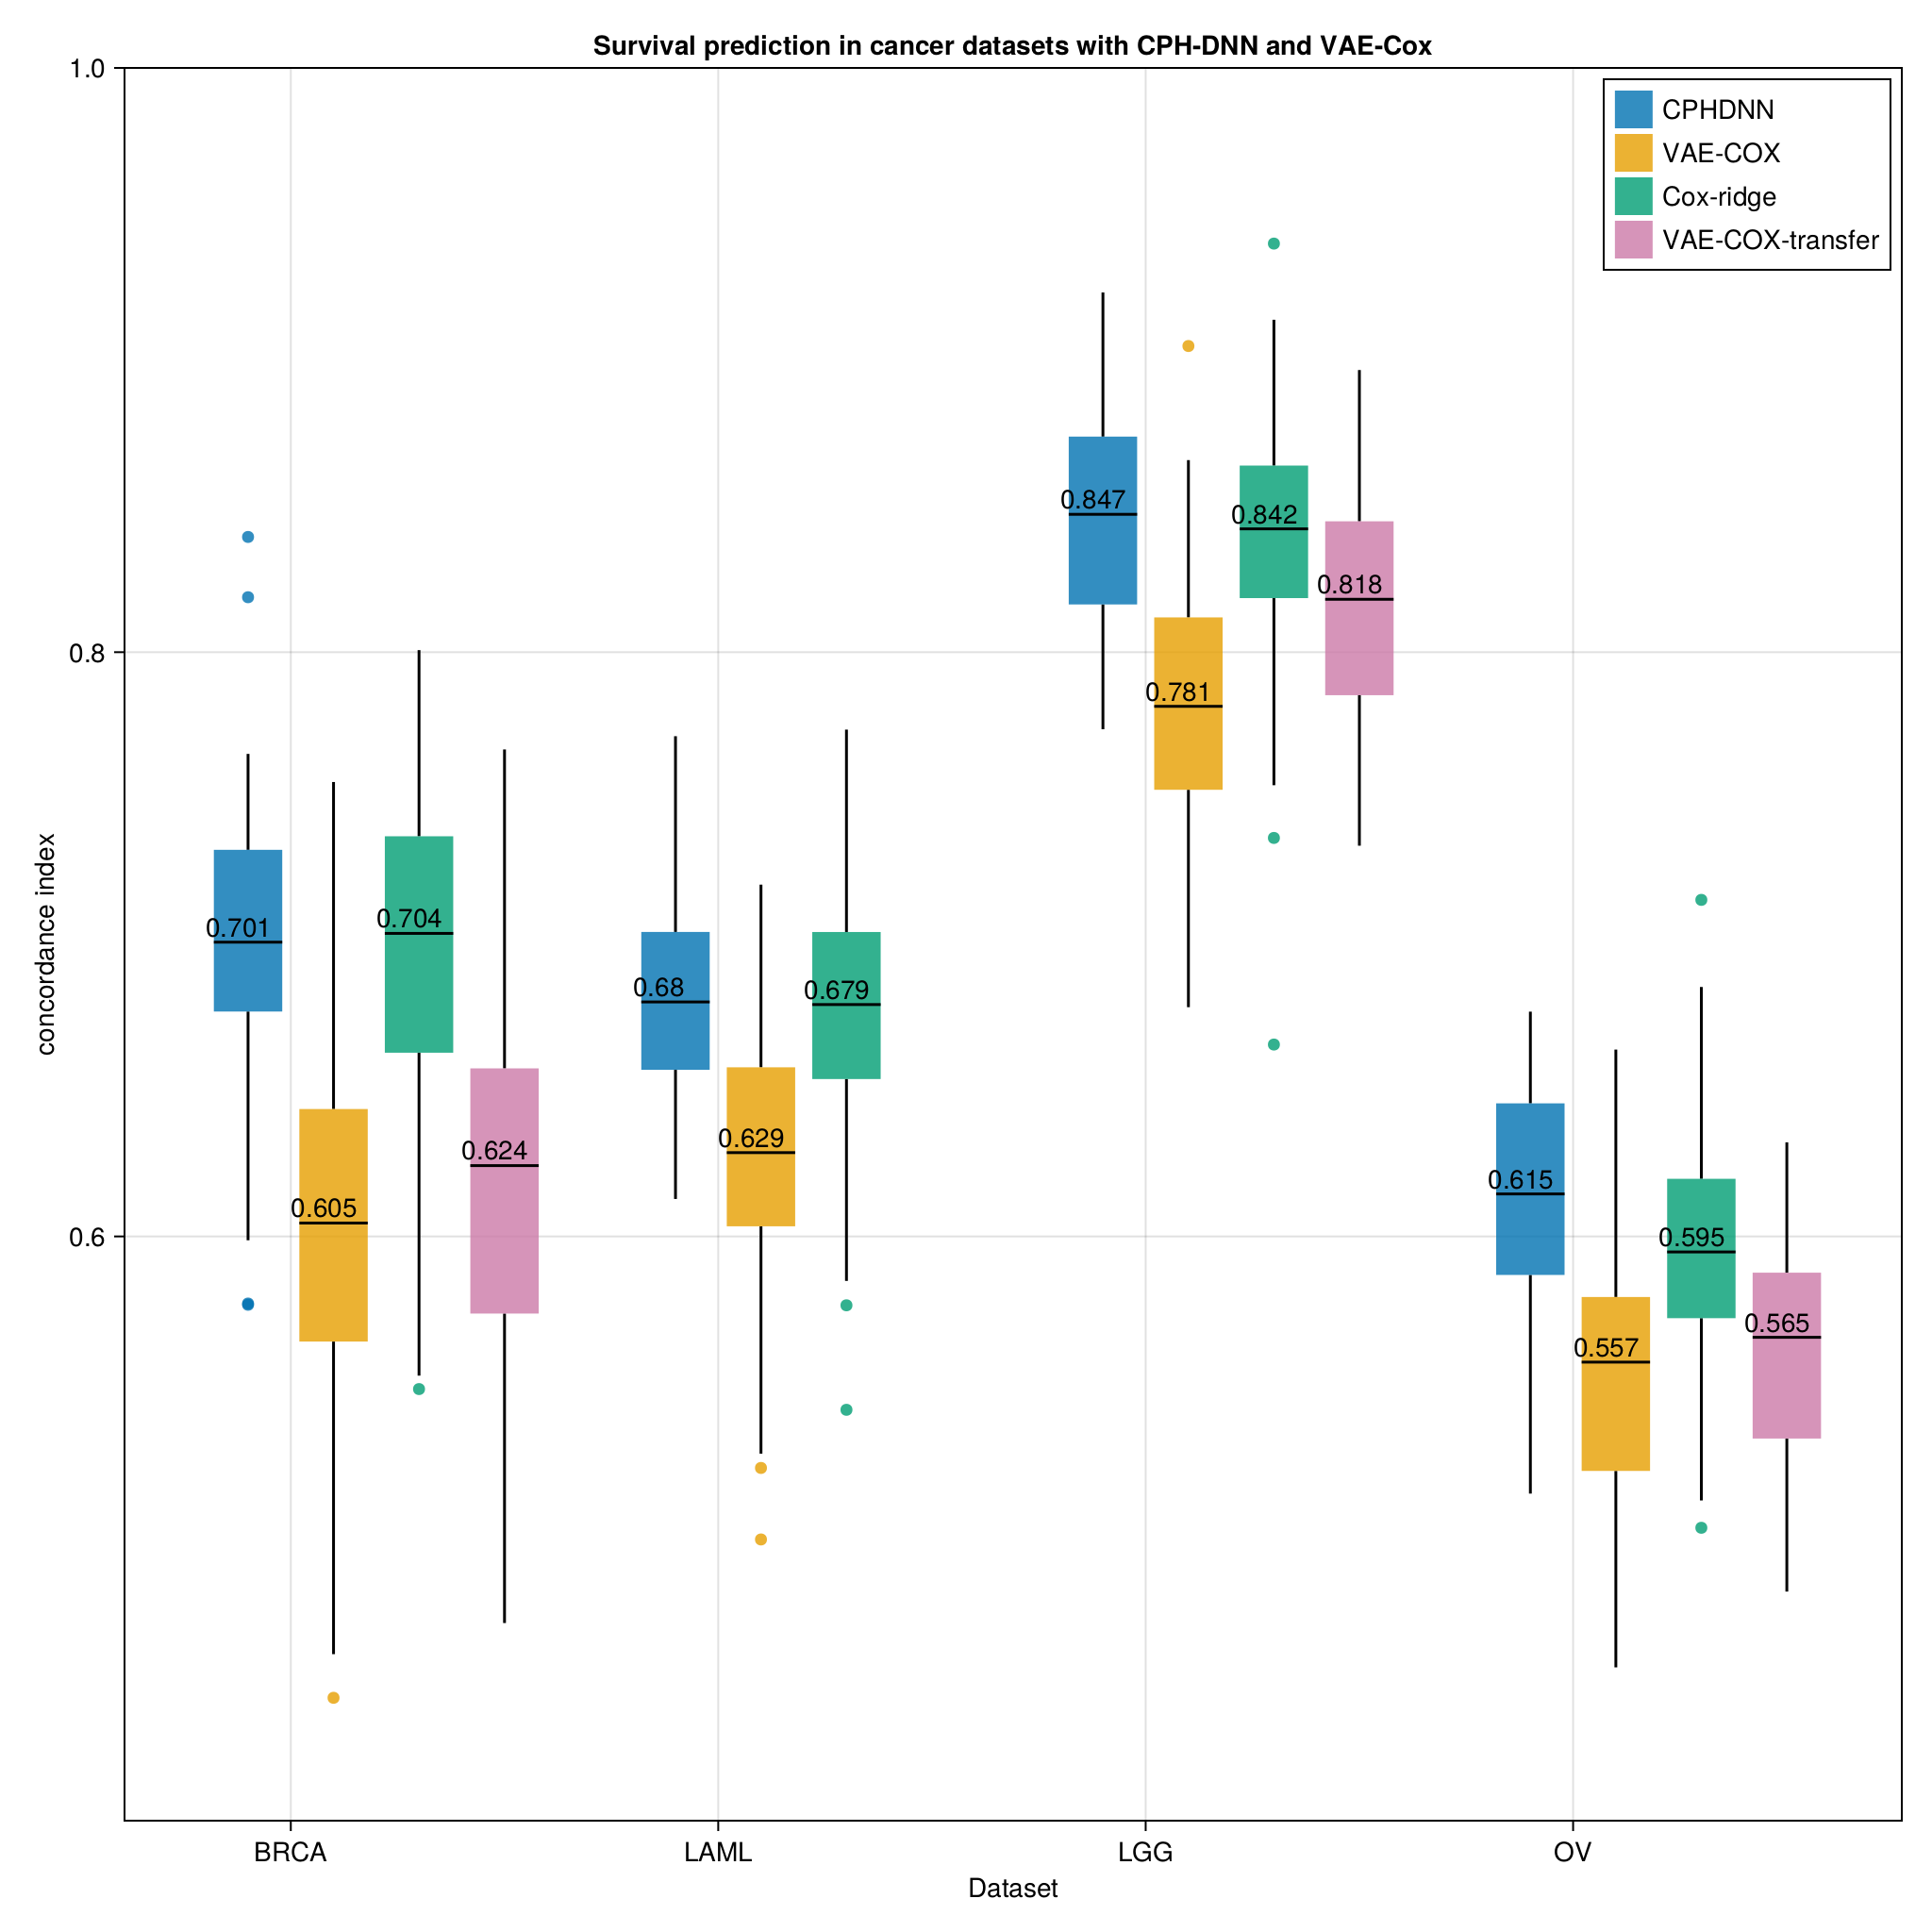

In [20]:

models[models.dataset .== "BRCA_data(norm=true)", "dataset"] .= "LAML"
#combine(groupby(cphdnn[:,["dataset", "cph_tst_c_ind"]], :dataset), :cph_tst_c_ind=>median) 
sorted_df = sort(models, :dataset)
sorted_df = leftjoin(sorted_df, DataFrame(:id =>collect(1:length(unique(sorted_df.dataset))), :dataset =>unique(sorted_df.dataset)), on = :dataset)

fig =  Figure(resolution = (1024,1024));
ax = Axis(fig[1,1],
    xticks = (collect(1:length(unique(sorted_df.dataset))), unique(sorted_df.dataset)), 
    title = "Survival prediction in cancer datasets with CPH-DNN and VAE-Cox",
    xlabel = "Dataset",
    ylabel = "concordance index",
    limits = (nothing, nothing, 0.4, 1))
boxplot!(ax, sorted_df.id[sorted_df.model_type .== "cphdnn_v5"] .- 0.1, width = 0.2,sorted_df[sorted_df.model_type .== "cphdnn_v5","cph_tst_c_ind"], label = "CPHDNN")
boxplot!(ax, sorted_df.id[sorted_df.model_type .== "vaecox_v4"] .+ 0.1, width = 0.2, sorted_df[sorted_df.model_type .== "vaecox_v4","cph_tst_c_ind"], label = "VAE-COX")
boxplot!(ax, sorted_df.id[sorted_df.model_type .== "cox_ridge"].+ 0.3, width = 0.2, sorted_df[sorted_df.model_type .== "cox_ridge","cph_tst_c_ind"], label = "Cox-ridge")
boxplot!(ax, sorted_df.id[sorted_df.model_type .== "vae_cox_transfer_v1"] .+ 0.5, width = 0.2,sorted_df[sorted_df.model_type .== "vae_cox_transfer_v1","cph_tst_c_ind"], label = "VAE-COX-transfer")

#scatter!(ax, sorted_df[:,"id"], sorted_df[:,"cph_tst_c_ind"])
medians = combine(groupby(sorted_df[:,["id", "model_type", "dataset", "cph_tst_c_ind"]], ["id","dataset", "model_type"]), :cph_tst_c_ind=>median) 
text!(ax, medians.id[medians.model_type .== "cphdnn_v5"] .- 0.2, medians[medians.model_type .== "cphdnn_v5",:].cph_tst_c_ind_median, text= string.(round.(medians[medians.model_type .== "cphdnn_v5",:].cph_tst_c_ind_median, digits = 3)))
text!(ax, medians.id[medians.model_type .== "vaecox_v4"], medians[medians.model_type .== "vaecox_v4",:].cph_tst_c_ind_median, text= string.(round.(medians[medians.model_type .== "vaecox_v4",:].cph_tst_c_ind_median, digits = 3)))
text!(ax, medians.id[medians.model_type .== "cox_ridge"] .+ 0.2, medians[medians.model_type .=="cox_ridge",:].cph_tst_c_ind_median, text= string.(round.(medians[medians.model_type .== "cox_ridge",:].cph_tst_c_ind_median, digits = 3)))
text!(ax, medians.id[medians.model_type .== "vae_cox_transfer_v1"] .+ 0.4, medians[medians.model_type .=="vae_cox_transfer_v1",:].cph_tst_c_ind_median, text= string.(round.(medians[medians.model_type .== "vae_cox_transfer_v1",:].cph_tst_c_ind_median, digits = 3)))

axislegend(ax, position = :rt)
CairoMakie.save("figures/cphdnn_vaecox_performance_multidatasets.svg",fig)
CairoMakie.save("figures/cphdnn_vaecox_performance_multidatasets.png",fig)
CairoMakie.save("figures/cphdnn_vaecox_performance_multidatasets.pdf",fig)
fig

In [79]:
brca_models= df[[x in ["cphdnn_v5", "vaecox_v4", "cox_ridge", "vae_cox_transfer_v1", "meta_cphdnn_v1", "meta_cox_ridge"] for x in df[:,"model_type"]],:]
brca_models= brca_models[brca_models.dataset .== "BRCA",:]
brca_models = innerjoin(brca_models, DataFrame("model_type"=>unique(brca_models.model_type), "ID" => collect(1:size(unique(brca_models.model_type))[1])), on = :model_type)
brca_models[brca_models.model_type .== "meta_cox_ridge","cph_tst_c_ind"];
#brca_models[brca_models.model_type .== "meta_cphdnn_v1","cph_tst_c_ind"]

100-element Vector{Float64}:
 0.7088709677419355
 0.7654476670870114
 0.7193846153846154
 0.6894664842681258
 0.6587565258661604
 0.76472481493402
 0.7433212996389892
 0.7278608976951072
 0.7307551988325429
 0.7535190176699611
 ⋮
 0.6756583172768144
 0.7363906301550643
 0.7541259683395083
 0.7268986157875047
 0.6970926301555105
 0.75625
 0.712742980561555
 0.7057811424638678
 0.7463729177861365

In [25]:
df = gather_params("RES/")
brca_models= df[[x in ["cphdnn_v5", "vaecox_v4", "cox_ridge", "vae_cox_transfer_v1", "meta_cphdnn_v1", "meta_cox_ridge"] for x in df[:,"model_type"]],:]
brca_models = brca_models[([!(x in [ "2024-01-26T14:02:47.799","2024-01-26T14:08:02.715"]) for x in brca_models.session_id]),:];
brca_models= brca_models[brca_models.dataset .== "BRCA",:]

Row,ae_lr,dim_redux,ae_nb_hls,nsamples,cph_wd,cph_hl_size,nepochs,venc_nb_hl,venc_hl_size,nsamples_test,nfolds,cph_lr,enc_nb_hl,enc_hl_size,dec_nb_hl,session_id,device,dec_hl_size,cph_nb_hl,machine_id,step,nsamples_train,modelid,ae_wd,ngenes,dataset,cph_tst_c_ind,model_title,nb_clinf,model_cv_complete,insize,model_type,cph_train_c_ind,vae_cor
,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,String,String,Int64,Int64,SubStrin…,Int64,Int64,String,Float64,Int64,String,Float64,String,Int64,Bool,Int64,String,Float64,Float32?
1,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,0c1e8a50ded1b225224a5,1.0e-6,19962,BRCA,0.713272,AECPHDNN,0,false,19962,cphdnn_v5,0.985607,missing
2,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,0d141f3d63164c318e493,1.0e-6,19962,BRCA,0.764335,AECPHDNN,0,false,19962,cphdnn_v5,0.99059,missing
3,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,15cb4d424d2c900fff10e,1.0e-6,19962,BRCA,0.693565,AECPHDNN,0,false,19962,cphdnn_v5,0.985777,missing
4,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,163eea5e5d9cc074ebc92,1.0e-6,19962,BRCA,0.745751,AECPHDNN,0,false,19962,cphdnn_v5,0.988566,missing
5,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,1e06a22fd60f075ca578b,1.0e-6,19962,BRCA,0.701878,AECPHDNN,0,false,19962,cphdnn_v5,0.988634,missing
6,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,289de0924649f7b62c431,1.0e-6,19962,BRCA,0.684707,AECPHDNN,0,false,19962,cphdnn_v5,0.984705,missing
7,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,2bc4d55d646364fa1e075,1.0e-6,19962,BRCA,0.699585,AECPHDNN,0,false,19962,cphdnn_v5,0.988743,missing
8,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,2ca632b02a1874103a0cd,1.0e-6,19962,BRCA,0.683364,AECPHDNN,0,false,19962,cphdnn_v5,0.984547,missing
9,1.0e-6,125,2,1049,0.0001,64,2000,2,128,210,5,1.0e-5,2,128,2,2024-01-16T15:31:16.898,CuDevice(0),128,2,iorek.iric.ca,2000,839,3bb420019b5c65f2f9bff,1.0e-6,19962,BRCA,0.73544,AECPHDNN,0,false,19962,cphdnn_v5,0.992279,missing


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /u/sauves/.local/share/julia_GenuineIntel/packages/Makie/fyNiH/src/scenes.jl:220


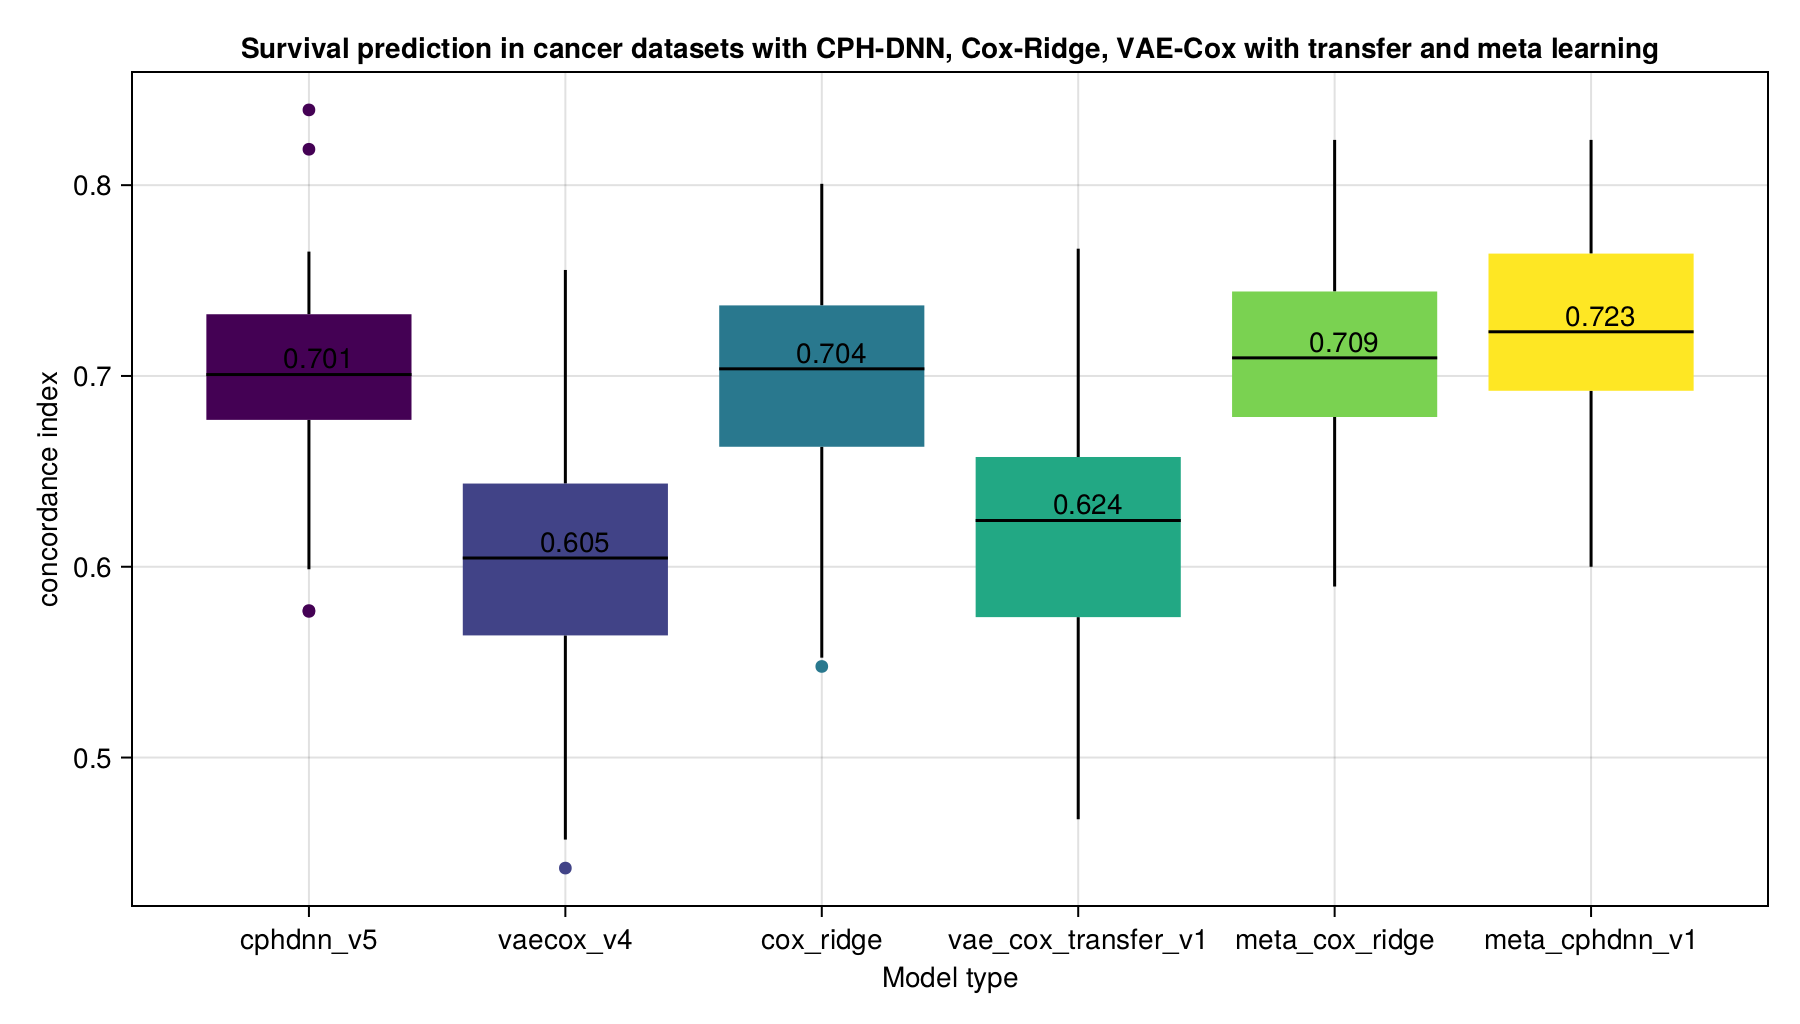

In [30]:
df = gather_params("RES/")
brca_models= df[[x in ["cphdnn_v5", "vaecox_v4", "cox_ridge", "vae_cox_transfer_v1", "meta_cphdnn_v1", "meta_cox_ridge"] for x in df[:,"model_type"]],:]
brca_models = brca_models[([!(x in [ "2024-01-26T14:02:47.799","2024-01-26T14:08:02.715"]) for x in brca_models.session_id]),:];
brca_models= brca_models[brca_models.dataset .== "BRCA",:]
brca_models = innerjoin(brca_models, DataFrame("model_type"=>unique(brca_models.model_type), "ID" => collect(1:size(unique(brca_models.model_type))[1])), on = :model_type)
fig =  Figure(resolution = (900,512));
ax = Axis(fig[1,1],
    xticks = (unique(brca_models.ID), unique(brca_models.model_type)), 
    title = "Survival prediction in cancer datasets with CPH-DNN, Cox-Ridge, VAE-Cox with transfer and meta learning",
    xlabel = "Model type",
    ylabel = "concordance index",
    )#limits = (nothing, nothing, 0.4, 1))
boxplot!(ax,brca_models.ID, brca_models.cph_tst_c_ind, color = brca_models.ID)
medians = combine(groupby(brca_models[:,["ID", "model_type",  "cph_tst_c_ind"]], ["ID","model_type"]), :cph_tst_c_ind=>median) 
text!(ax, medians.ID .- 0.1, medians.cph_tst_c_ind_median, text= string.(round.(medians.cph_tst_c_ind_median, digits = 3)))
CairoMakie.save("figures/models_performance_brca.svg",fig)
CairoMakie.save("figures/models_performance_brca.png",fig)
CairoMakie.save("figures/models_performance_brca.pdf",fig)
#axislegend(ax, position = :rt)
fig

In [53]:
medians = combine(groupby(brca_models[:,["ID", "model_type",  "cph_tst_c_ind"]], ["ID","model_type"]), :cph_tst_c_ind=>median) 


Row,ID,model_type,cph_tst_c_ind_median
,Int64,String,Float64
1,1,cphdnn_v5,0.700731
2,2,vaecox_v4,0.604583
3,3,cox_ridge,0.703736
4,4,vae_cox_transfer_v1,0.624242
5,5,meta_cphdnn_v1,0.719921
6,6,meta_cox_ridge,0.665002


In [26]:
medians = combine(groupby(sorted_df[:,["id", "model_type", "dataset", "cph_tst_c_ind"]], ["id","dataset", "model_type"]), :cph_tst_c_ind=>median) 
medians[medians.model_type .== "cphdnn_v5",:].cph_tst_c_ind_median
medians.id[medians.model_type .== "cphdnn_v5"] .- 0.1
medians = combine(groupby(sorted_df[:,["id", "model_type", "dataset", "cph_tst_c_ind"]], ["id","dataset", "model_type"]), :cph_tst_c_ind=>median) 
text!(ax, medians.id[medians.model_type .== "cphdnn_v5"] .- 0.1, medians[medians.model_type .== "cphdnn_v5",:].cph_tst_c_ind_median, text= string.(round.(medians.cph_tst_c_ind_median, digits = 3)))


MakieCore.Text{Tuple{Vector{Point{2, Float32}}}}

unique(models.model_type)

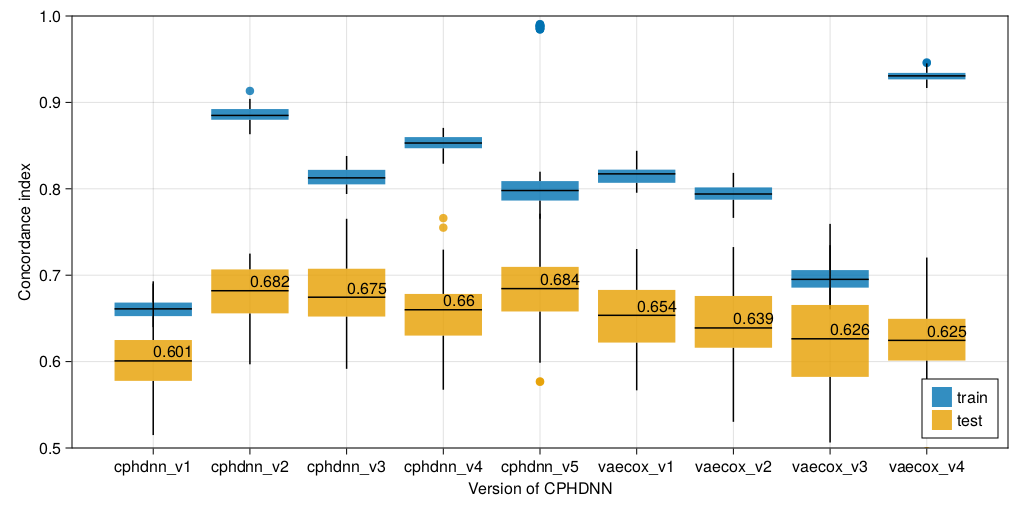

In [65]:
sorted_df = sort(df, :model_type)
sorted_df = leftjoin(sorted_df, DataFrame(:id =>collect(1:length(unique(sorted_df.model_type))), :model_type =>unique(sorted_df.model_type)), on = :model_type)

fig = Figure(resolution = (1024,512));
ax = Axis(fig[1,1],
    ylabel = "Concordance index", 
    xlabel = "Version of CPHDNN",
    limits = (nothing, nothing, 0.5, 1),
    xticks = (collect(1:length(unique(sorted_df.model_type))), unique(sorted_df.model_type)))#(log2.(unique(V1[:, "dim_redux"])), ["$x" for x in unique(V1_2[:, "dim_redux"])] ));
boxplot!(ax, sorted_df.id, sorted_df[:,"cph_train_c_ind"], label = "train")
boxplot!(ax, sorted_df.id, sorted_df[:,"cph_tst_c_ind"], label = "test")
medians = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>median) 
text!(ax, medians.id, medians.cph_tst_c_ind_median, text= string.(round.(medians.cph_tst_c_ind_median, digits = 3)))
#scatter!(ax, , V1[:,"cph_tst_c_ind"], label = "test")
axislegend(ax,position =:rb)
fig

In [10]:
medians = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>median) 
string.(round.(medians.cph_tst_c_ind_median, digits = 3))

7-element Vector{String}:
 "0.601"
 "0.682"
 "0.675"
 "0.66"
 "0.68"
 "0.654"
 "0.639"

In [13]:
median(df[df.model_type .== "vaecox_v2","cph_tst_c_ind"])
sorted_df[sorted_df.model_type .== "vaecox_v2",:]

,ae_lr,dim_redux,ae_nb_hls,nsamples,cph_wd,cph_hl_size,nepochs,venc_nb_hl
,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64
1,1.0e-6,125,2,300,0.0001,64,10000,2
2,1.0e-6,125,2,300,0.0001,64,10000,2
3,1.0e-6,125,2,300,0.0001,64,10000,2
4,1.0e-6,125,2,300,0.0001,64,10000,2
5,1.0e-6,125,2,300,0.0001,64,10000,2
6,1.0e-6,125,2,300,0.0001,64,10000,2
7,1.0e-6,125,2,300,0.0001,64,10000,2
8,1.0e-6,125,2,300,0.0001,64,10000,2
9,1.0e-6,125,2,300,0.0001,64,10000,2


In [322]:
means = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>mean) 

,id,cph_tst_c_ind_mean
,Int64?,Float64
1,1,0.595233
2,2,0.669938
3,3,0.678311
4,4,0.656278
5,5,0.678584
6,6,0.650901


In [324]:
means.id

6-element Vector{Union{Missing, Int64}}:
 1
 2
 3
 4
 5
 6